In [1]:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn statsmodels prophet torch

  Using cached yfinance-0.2.64-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached pandas-2.3.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.3.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached statsmodels-0.14.4-cp313-cp313-win_amd64.whl.metadata (9.5 kB)
  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached torch-2.7.1-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached frozendict-2.4.6-py313-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.1-py3-none-any.whl
  Using cached beautifulsoup4-4.13.4-p

In [2]:
# 验证安装/installation check
import torch
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")

PyTorch版本: 2.7.1+cpu
CUDA可用: False


In [3]:
# 步骤2：导入所有依赖库 (优化版)
# Step 2: Import All Dependencies (Optimized)
# ===========================================
import os
import warnings

# 禁用不必要的警告
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 禁用TensorFlow日志（即使不使用）
os.environ['PROPHET_PLOT_BACKEND'] = 'matplotlib'  # 强制Prophet使用Matplotlib

# 导入核心库
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(rc={'figure.figsize':(12,6)})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

print("所有依赖库已成功导入 / All dependencies imported successfully")

Importing plotly failed. Interactive plots will not work.


所有依赖库已成功导入 / All dependencies imported successfully


In [4]:
# 步骤3：配置参数（用户可修改区域）
# Step 3: Configuration Parameters (User Editable Area)
# ===================================================
# ********** 请在此修改预测参数 **********
# ********** Modify Prediction Parameters Here **********

TICKER = 'TSLA'       # 股票代码 / Stock ticker (e.g. 'MSFT', 'GOOGL')
START_DATE = '2020-01-01'  # 开始日期 / Start date (YYYY-MM-DD)
END_DATE = '2025-7-1'    # 结束日期 / End date (YYYY-MM-DD)
SEQ_LENGTH = 60           # 序列长度 / Sequence length (建议60-100 / Recommended 60-100)
TRAIN_RATIO = 0.8         # 训练集比例 / Training set ratio (0.7-0.9)
EPOCHS = 100              # 训练轮数 / Training epochs (建议50-200 / Recommended 50-200)
LEARNING_RATE = 0.001     # 学习率 / Learning rate
BATCH_SIZE = 64           # 批大小 / Batch size

# ********** 高级参数（可选修改）**********
# ********** Advanced Parameters (Optional) **********

LSTM_HIDDEN_SIZE = 64     # LSTM隐藏层大小 / LSTM hidden layer size
LSTM_NUM_LAYERS = 2       # LSTM层数 / Number of LSTM layers
ARIMA_ORDER = (5, 1, 0)   # ARIMA参数 (p,d,q) / ARIMA parameters (p,d,q)
FORECAST_DAYS = 30        # 未来预测天数 / Days to forecast into future

print(f"配置参数设置完成 / Configuration parameters set")
print(f"股票代码: {TICKER}, 时间范围: {START_DATE} 至 {END_DATE}")

配置参数设置完成 / Configuration parameters set
股票代码: TSLA, 时间范围: 2020-01-01 至 2025-7-1


正在下载 TSLA 股票数据...


[*********************100%***********************]  1 of 1 completed

数据下载完成，共 1380 条记录
日期范围: 2020-01-02 至 2025-06-30

数据预览:


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


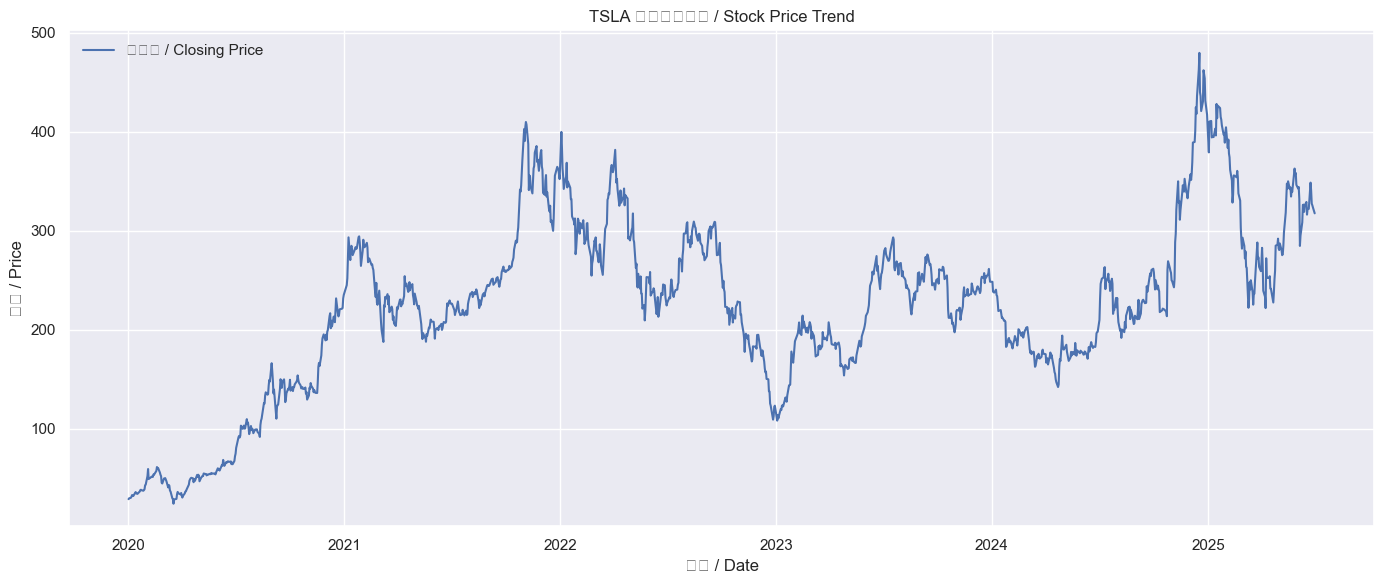

In [5]:
# 步骤4：下载股票数据
# Step 4: Download Stock Data
# ============================
def download_stock_data(ticker, start_date, end_date):
    """下载股票数据 / Download stock data"""
    print(f"正在下载 {ticker} 股票数据...")
    data = yf.download(ticker, start=start_date, end=end_date)
    print(f"数据下载完成，共 {len(data)} 条记录")
    print(f"日期范围: {data.index[0].date()} 至 {data.index[-1].date()}")
    return data

# 下载数据
stock_data = download_stock_data(TICKER, START_DATE, END_DATE)

# 显示前5行数据
print("\n数据预览:")
display(stock_data.head())

# 绘制价格走势
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Close'], label='收盘价 / Closing Price')
plt.title(f'{TICKER} 股票价格走势 / Stock Price Trend')
plt.xlabel('日期 / Date')
plt.ylabel('价格 / Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

数据集大小 / Dataset Sizes:
训练集: 1104 条 / Training set: 1104 records
测试集: 336 条 / Test set: 336 records


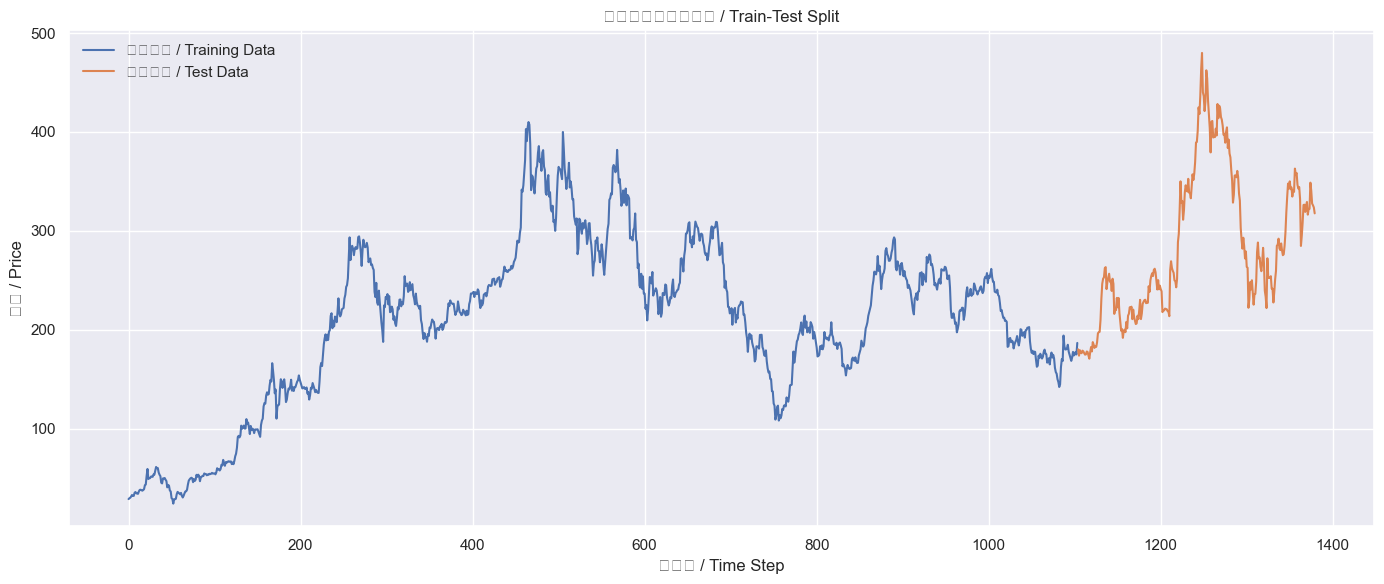

In [6]:
# 步骤5：数据预处理
# Step 5: Data Preprocessing
# ===========================
def preprocess_data(data, target_column='Close'):
    """预处理数据 / Preprocess data"""
    # 提取目标列
    target = data[target_column].values.reshape(-1, 1)
    
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(target)
    
    return scaled_data, scaler, target

# 预处理
scaled_data, scaler, original_data = preprocess_data(stock_data)

# 划分训练集和测试集
train_size = int(len(scaled_data) * TRAIN_RATIO)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQ_LENGTH:]  # 包含部分重叠数据

print(f"数据集大小 / Dataset Sizes:")
print(f"训练集: {len(train_data)} 条 / Training set: {len(train_data)} records")
print(f"测试集: {len(test_data)} 条 / Test set: {len(test_data)} records")

# 可视化数据划分
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(train_data)), scaler.inverse_transform(train_data), label='训练数据 / Training Data')
plt.plot(np.arange(len(train_data), len(train_data)+len(test_data)-SEQ_LENGTH), 
         scaler.inverse_transform(test_data)[SEQ_LENGTH:], label='测试数据 / Test Data')
plt.title('训练集和测试集划分 / Train-Test Split')
plt.xlabel('时间步 / Time Step')
plt.ylabel('价格 / Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

训练数据集大小: 1044 个序列
测试数据集大小: 276 个序列
批次数量: 17 个训练批次, 5 个测试批次


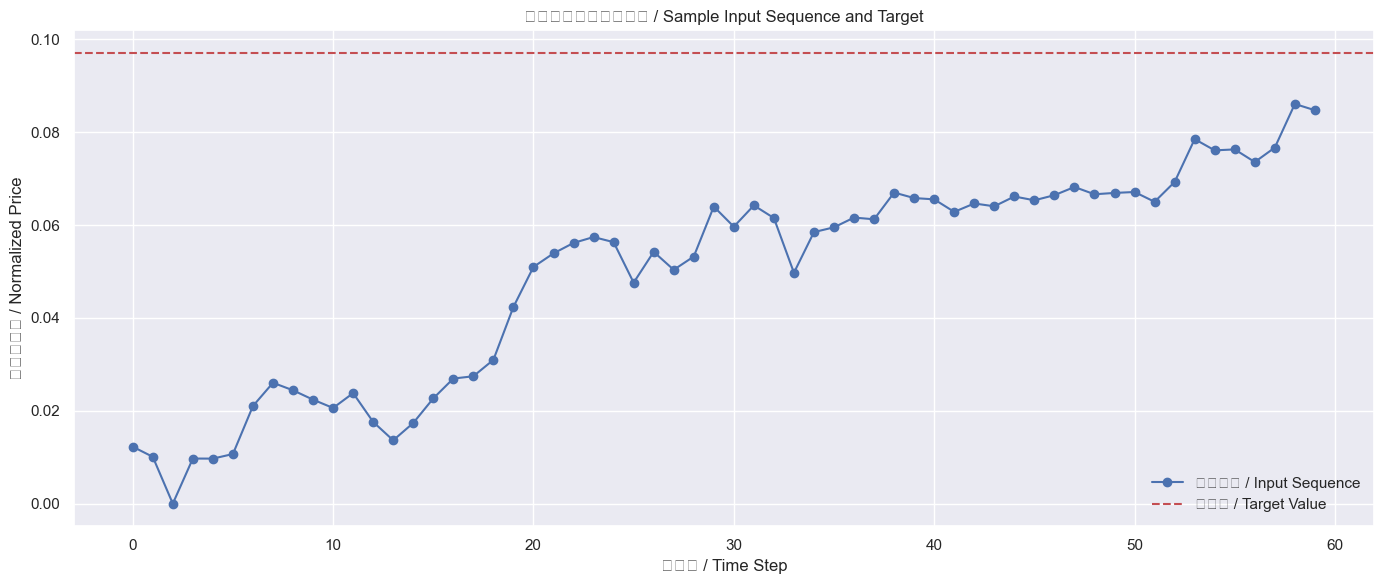

In [7]:
# 步骤6：创建数据集类
# Step 6: Create Dataset Class
# =============================
class StockDataset(Dataset):
    """股票数据集类 / Stock Dataset Class"""
    def __init__(self, data, sequence_length=60):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.sequence_length]
        y = self.data[idx+self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 创建数据集
train_dataset = StockDataset(train_data.flatten(), SEQ_LENGTH)
test_dataset = StockDataset(test_data.flatten(), SEQ_LENGTH)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 打印数据集信息
print(f"训练数据集大小: {len(train_dataset)} 个序列")
print(f"测试数据集大小: {len(test_dataset)} 个序列")
print(f"批次数量: {len(train_loader)} 个训练批次, {len(test_loader)} 个测试批次")

# 可视化一个样本序列
sample_idx = 50
sample_seq, sample_target = train_dataset[sample_idx]
plt.figure(figsize=(14, 6))
plt.plot(sample_seq.numpy(), 'o-', label='输入序列 / Input Sequence')
plt.axhline(y=sample_target.numpy(), color='r', linestyle='--', label='目标值 / Target Value')
plt.title('样本输入序列和目标值 / Sample Input Sequence and Target')
plt.xlabel('时间步 / Time Step')
plt.ylabel('归一化价格 / Normalized Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# 步骤7：定义LSTM模型
# Step 7: Define LSTM Model
# ==========================
class LSTMModel(nn.Module):
    """LSTM预测模型 / LSTM Forecasting Model"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # 初始化隐藏状态 - 使用正确的维度
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = LSTMModel(
    input_size=1, 
    hidden_size=LSTM_HIDDEN_SIZE, 
    num_layers=LSTM_NUM_LAYERS, 
    output_size=1
).to(device)

# 打印模型结构
print("LSTM模型结构:")
print(model)

使用设备: cpu
LSTM模型结构:
LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


开始训练LSTM模型...
Epoch [1/100], Batch [10/17], Loss: 0.047307
Epoch [1/100], Avg Loss: 0.087437
Epoch [2/100], Batch [10/17], Loss: 0.032512
Epoch [2/100], Avg Loss: 0.026588
Epoch [3/100], Batch [10/17], Loss: 0.019241
Epoch [3/100], Avg Loss: 0.022521
Epoch [4/100], Batch [10/17], Loss: 0.017057
Epoch [4/100], Avg Loss: 0.018925
Epoch [5/100], Batch [10/17], Loss: 0.006301
Epoch [5/100], Avg Loss: 0.008238
Epoch [6/100], Batch [10/17], Loss: 0.005056
Epoch [6/100], Avg Loss: 0.005121
Epoch [7/100], Batch [10/17], Loss: 0.003869
Epoch [7/100], Avg Loss: 0.003380
Epoch [8/100], Batch [10/17], Loss: 0.002569
Epoch [8/100], Avg Loss: 0.002595
Epoch [9/100], Batch [10/17], Loss: 0.001809
Epoch [9/100], Avg Loss: 0.002023
Epoch [10/100], Batch [10/17], Loss: 0.001942
Epoch [10/100], Avg Loss: 0.001958
Epoch [11/100], Batch [10/17], Loss: 0.002555
Epoch [11/100], Avg Loss: 0.002111
Epoch [12/100], Batch [10/17], Loss: 0.002125
Epoch [12/100], Avg Loss: 0.002140
Epoch [13/100], Batch [10/17], L

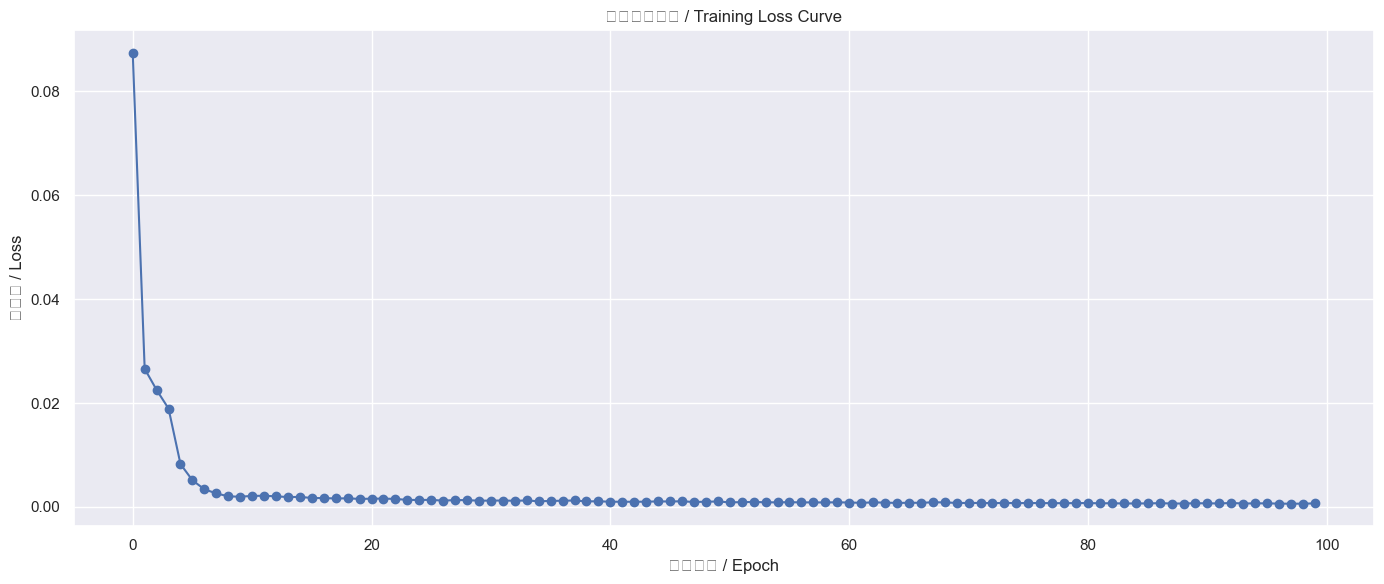

In [9]:
# 步骤8：训练LSTM模型
# Step 8: Train LSTM Model
# =========================
def train_lstm_model(model, train_loader, criterion, optimizer, num_epochs=100):
    """训练LSTM模型 / Train LSTM Model"""
    model.train()
    losses = []
    
    print("开始训练LSTM模型...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 清除之前的梯度
            optimizer.zero_grad()
            
            # 前向传播 - 添加正确的维度
            outputs = model(inputs.unsqueeze(-1))  # 添加特征维度
            
            # 计算损失
            loss = criterion(outputs.squeeze(), targets)
            
            # 反向传播
            loss.backward()
            
            # 裁剪梯度防止爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # 更新参数
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # 每10个批次打印一次进度
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.6f}")
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 1 == 0:  # 每个epoch都打印
            print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_epoch_loss:.6f}")
    
    print("LSTM模型训练完成")
    
    # 保存模型
    torch.save(model.state_dict(), f'{TICKER}_lstm_model.pth')
    print(f"模型已保存到 {TICKER}_lstm_model.pth")
    
    return losses

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 训练模型
loss_history = train_lstm_model(model, train_loader, criterion, optimizer, EPOCHS)

# 绘制损失曲线
plt.figure(figsize=(14, 6))
plt.plot(loss_history, 'o-')
plt.title('训练损失曲线 / Training Loss Curve')
plt.xlabel('训练轮数 / Epoch')
plt.ylabel('损失值 / Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{TICKER}_training_loss.png')  # 保存图表
plt.show()

模型评估结果:
均方根误差 (RMSE): 16.2599
平均绝对误差 (MAE): 12.8775
LSTM预测日期范围: 2024-05-22 00:00:00 到 2025-06-30 00:00:00
预测值数量: 276


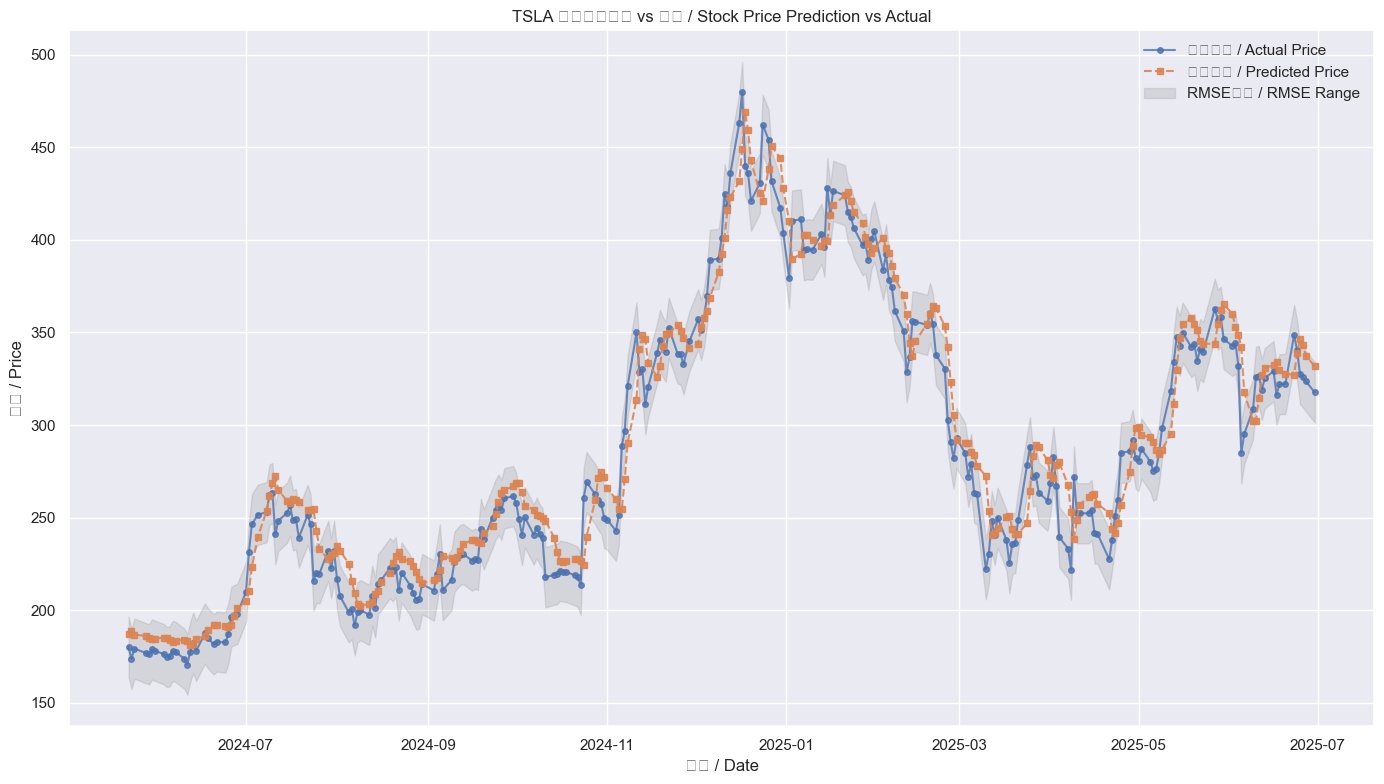


预测结果对比 (最后10个数据点):


,Actual,Predicted,Error,Abs_Error
Date,,,,
2025-06-16,329.130001,332.425137,3.295136,3.295136
2025-06-17,316.349998,334.239508,17.889510,17.889510
2025-06-18,322.049997,329.822910,7.772913,7.772913
2025-06-20,322.159994,327.596640,5.436646,5.436646
2025-06-23,348.679983,327.162900,-21.517083,21.517083
2025-06-24,340.470014,338.961756,-1.508258,1.508258
2025-06-25,327.549996,346.457571,18.907575,18.907575
2025-06-26,325.779988,343.491448,17.711460,17.711460
2025-06-27,323.630002,337.341789,13.711787,13.711787


预测结果已保存到 TSLA_prediction_results.csv


In [10]:
# 步骤9：评估LSTM模型 (日期索引修复版)
# Step 9: Evaluate LSTM Model (Date Index Fix)
# ===========================================
def evaluate_model(model, test_loader, scaler, stock_data, train_size, seq_length):
    """评估模型性能 / Evaluate Model Performance (Date Index Fix)"""
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            
            # 前向传播
            outputs = model(inputs.unsqueeze(-1))  # 添加特征维度
            
            predictions.extend(outputs.cpu().squeeze().tolist())
            true_values.extend(targets.cpu().tolist())
    
    # 确保所有数组长度一致
    n_samples = min(len(predictions), len(true_values))
    predictions = np.array(predictions[:n_samples]).reshape(-1, 1)
    true_values = np.array(true_values[:n_samples]).reshape(-1, 1)
    
    predictions = scaler.inverse_transform(predictions)
    true_values = scaler.inverse_transform(true_values)
    
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    
    print(f"模型评估结果:")
    print(f"均方根误差 (RMSE): {rmse:.4f}")
    print(f"平均绝对误差 (MAE): {mae:.4f}")
    
    # 正确计算日期索引
    # 训练集结束后的第一个预测点索引
    start_idx = train_size
    
    # 确保起始索引在有效范围内
    if start_idx >= len(stock_data):
        # 如果超出范围，从最后一个日期开始
        last_date = stock_data.index[-1]
        date_index = pd.date_range(start=last_date, periods=n_samples)
        print(f"警告: 使用新日期索引 {date_index[0]} 到 {date_index[-1]}")
    else:
        # 获取原始日期索引
        end_idx = min(start_idx + n_samples, len(stock_data))
        date_index = stock_data.index[start_idx:end_idx]
        
        # 如果长度不匹配，补充缺失日期
        if len(date_index) < n_samples:
            n_missing = n_samples - len(date_index)
            last_date = date_index[-1] if len(date_index) > 0 else stock_data.index[-1]
            additional_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_missing)
            date_index = date_index.append(additional_dates)
    
    return predictions, true_values, rmse, mae, date_index

# 确保模型已加载
if 'model' not in locals():
    print("加载已保存的模型...")
    model = LSTMModel(
        input_size=1, 
        hidden_size=LSTM_HIDDEN_SIZE, 
        num_layers=LSTM_NUM_LAYERS, 
        output_size=1
    ).to(device)
    model.load_state_dict(torch.load(f'{TICKER}_lstm_model.pth'))
    print(f"模型已从 {TICKER}_lstm_model.pth 加载")

# 评估模型
predictions, true_values, rmse, mae, date_index = evaluate_model(
    model, test_loader, scaler, stock_data, train_size, SEQ_LENGTH
)

# 打印日期范围信息
print(f"LSTM预测日期范围: {date_index[0]} 到 {date_index[-1]}")
print(f"预测值数量: {len(predictions)}")

# 创建结果DataFrame
results_df = pd.DataFrame({
    'Date': date_index,
    'Actual': true_values.flatten(),
    'Predicted': predictions.flatten()
}).set_index('Date')

# 计算预测误差
results_df['Error'] = results_df['Predicted'] - results_df['Actual']
results_df['Abs_Error'] = results_df['Error'].abs()

# 可视化预测结果
plt.figure(figsize=(14, 8))
plt.plot(results_df.index, results_df['Actual'], 'o-', label='实际价格 / Actual Price', alpha=0.8, markersize=4)
plt.plot(results_df.index, results_df['Predicted'], 's--', label='预测价格 / Predicted Price', alpha=0.9, markersize=4)
plt.fill_between(results_df.index, 
                results_df['Actual'] - rmse, 
                results_df['Actual'] + rmse, 
                color='gray', alpha=0.2, label='RMSE范围 / RMSE Range')
plt.title(f'{TICKER} 股票价格预测 vs 实际 / Stock Price Prediction vs Actual')
plt.xlabel('日期 / Date')
plt.ylabel('价格 / Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{TICKER}_prediction_vs_actual.png')  # 保存图表
plt.show()

# 显示最后10个预测结果
print("\n预测结果对比 (最后10个数据点):")
display(results_df.tail(10))

# 保存结果到CSV
results_df.to_csv(f'{TICKER}_prediction_results.csv')
print(f"预测结果已保存到 {TICKER}_prediction_results.csv")


数据平稳性检验:
ADF统计量: -2.8554
p值: 0.0508
临界值:
   1%: -3.4352
   5%: -2.8637
   10%: -2.5679
结论: 数据非平稳 (p值 > 0.05)


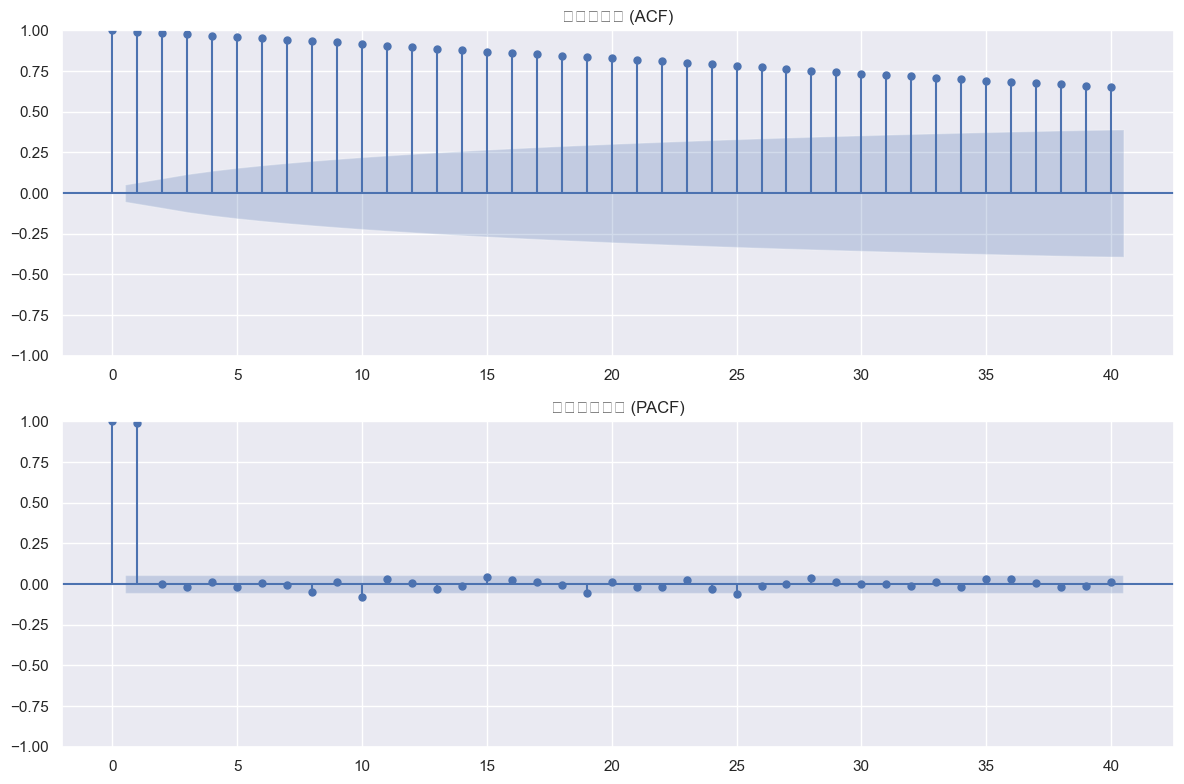


pmdarima未安装，使用预设参数
数据非平稳，尝试ARIMA(1,1,1)或(2,1,2)
将使用ARIMA参数: (2, 1, 2)

使用ARIMA(2, 1, 2)模型进行预测...

模型摘要:


c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1380
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5050.315
Date:                Fri, 04 Jul 2025   AIC                          10110.630
Time:                        17:03:11   BIC                          10136.776
Sample:                             0   HQIC                         10120.411
                               - 1380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1517      1.878     -0.081      0.936      -3.833       3.530
ar.L2          0.2696      1.433      0.188      0.851      -2.539       3.078
ma.L1          0.1373      1.886      0.073      0.9

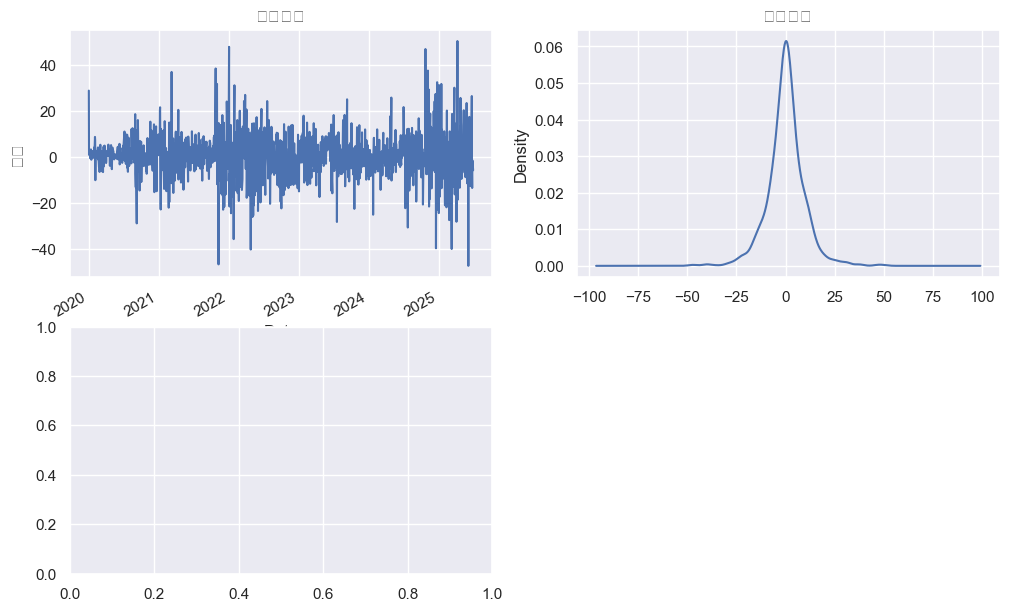

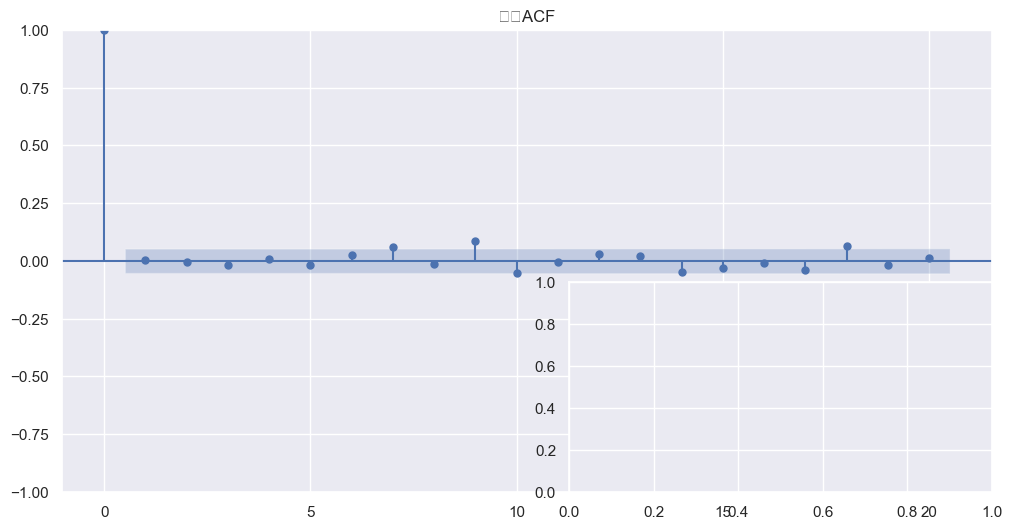

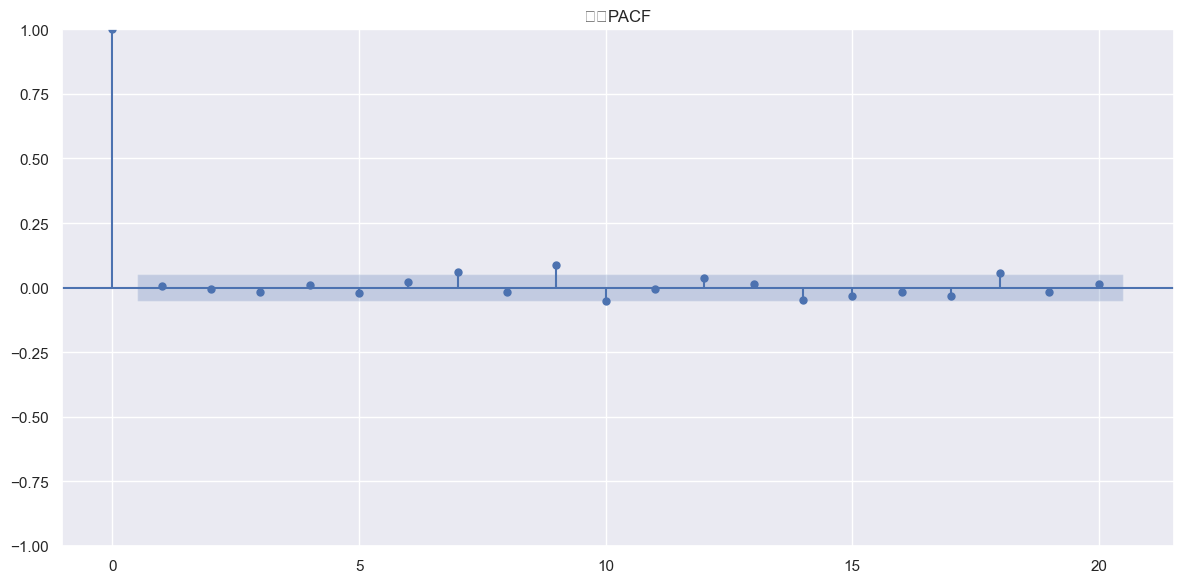

c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


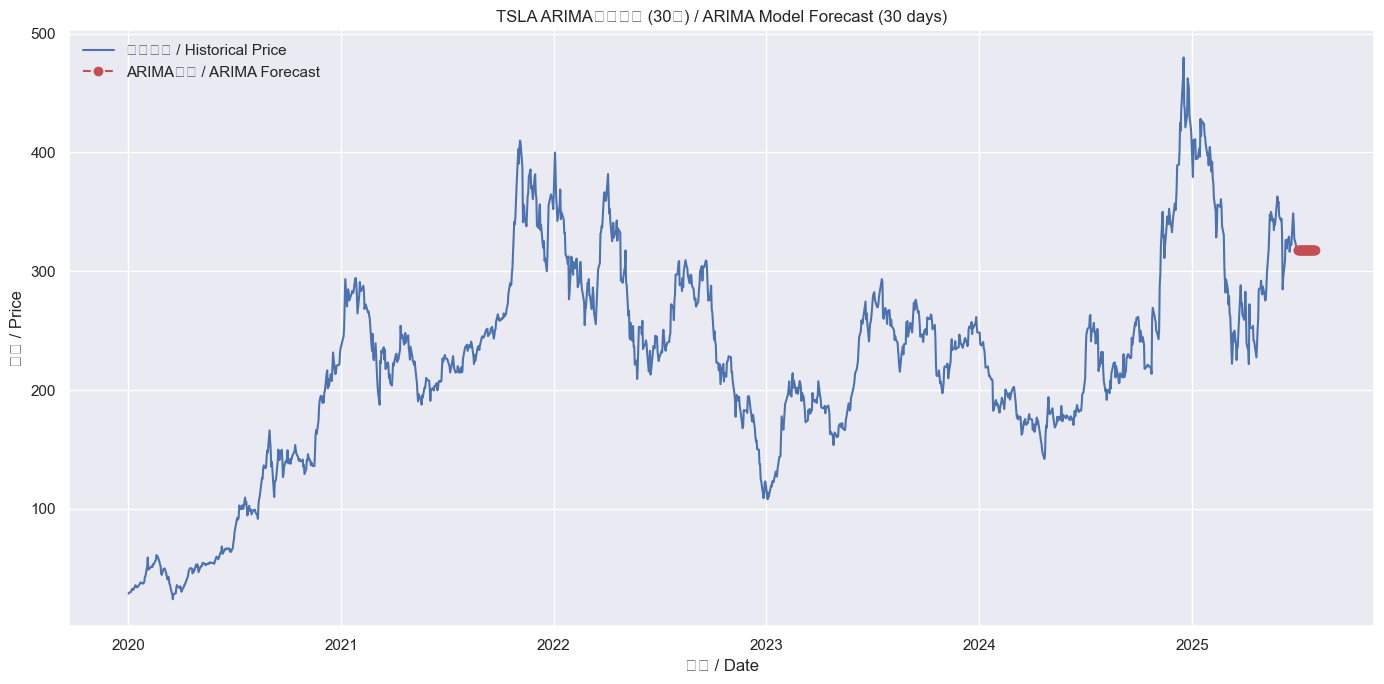

ARIMA预测结果 (未来30天):


,ARIMA_Forecast
Date,
2025-07-01,317.713895
2025-07-02,317.588120
2025-07-03,317.621733
2025-07-04,317.582725
2025-07-05,317.597706
2025-07-06,317.584917
2025-07-07,317.590896
2025-07-08,317.586541
2025-07-09,317.588814


In [11]:
# 步骤10：改进的ARIMA模型预测（添加诊断和自动参数选择）
# Step 10: Improved ARIMA Model Forecasting (with Diagnostics and Auto Parameter Selection)
# ===========================================================================

# 首先检查数据平稳性
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    """检查数据平稳性 / Check data stationarity"""
    print("\n数据平稳性检验:")
    result = adfuller(data)
    print(f'ADF统计量: {result[0]:.4f}')
    print(f'p值: {result[1]:.4f}')
    print('临界值:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] <= 0.05:
        print("结论: 数据是平稳的 (p值 < 0.05)")
        return True
    else:
        print("结论: 数据非平稳 (p值 > 0.05)")
        return False

# 检查收盘价数据的平稳性
stationary = check_stationarity(stock_data['Close'])

# 可视化ACF和PACF图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 自相关图 (ACF)
plot_acf(stock_data['Close'], lags=40, ax=ax1)
ax1.set_title('自相关函数 (ACF)')

# 偏自相关图 (PACF)
plot_pacf(stock_data['Close'], lags=40, ax=ax2)
ax2.set_title('偏自相关函数 (PACF)')

plt.tight_layout()
plt.savefig(f'{TICKER}_acf_pacf.png')
plt.show()

# 尝试自动选择ARIMA参数（如果安装pmdarima）
try:
    import pmdarima as pm
    print("\n使用pmdarima自动选择最佳ARIMA参数...")
    auto_arima = pm.auto_arima(
        stock_data['Close'],
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        trace=True
    )
    best_order = auto_arima.order
    print(f"自动选择的最佳ARIMA参数: {best_order}")
    ARIMA_ORDER = best_order  # 更新为最佳参数
except ImportError:
    print("\npmdarima未安装，使用预设参数")
    # 根据ACF/PACF图调整参数
    if stationary:
        print("数据平稳，尝试ARIMA(1,0,1)或(2,0,2)")
        ARIMA_ORDER = (2, 0, 2)  # 平稳数据的参数
    else:
        print("数据非平稳，尝试ARIMA(1,1,1)或(2,1,2)")
        ARIMA_ORDER = (2, 1, 2)  # 非平稳数据的参数

print(f"将使用ARIMA参数: {ARIMA_ORDER}")

def robust_arima_forecast(data, order=ARIMA_ORDER, forecast_days=30):
    """健壮的ARIMA预测 / Robust ARIMA Forecasting"""
    print(f"\n使用ARIMA{order}模型进行预测...")
    try:
        # 拟合模型
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        
        # 模型诊断
        print("\n模型摘要:")
        print(model_fit.summary())
        
        # 绘制残差诊断图
        residuals = model_fit.resid
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        residuals.plot(title='残差序列')
        plt.ylabel('残差')
        
        plt.subplot(2, 2, 2)
        residuals.plot(kind='kde', title='残差密度')
        
        plt.subplot(2, 2, 3)
        plot_acf(residuals, lags=20, title='残差ACF')
        
        plt.subplot(2, 2, 4)
        plot_pacf(residuals, lags=20, title='残差PACF')
        
        plt.tight_layout()
        plt.savefig(f'{TICKER}_arima_residuals.png')
        plt.show()
        
        # 进行预测
        forecast = model_fit.forecast(steps=forecast_days)
        return forecast.values
    except Exception as e:
        print(f"ARIMA预测失败: {e}")
        print("使用简单移动平均作为备选预测")
        # 备选预测：使用最近30天的加权平均
        weights = np.linspace(0.1, 1.0, min(30, len(data)))
        weights /= weights.sum()
        last_30_days = data[-len(weights):].values
        weighted_avg = np.sum(last_30_days * weights)
        return np.array([weighted_avg] * forecast_days)

# 使用改进的ARIMA预测
arima_pred = robust_arima_forecast(stock_data['Close'], ARIMA_ORDER, FORECAST_DAYS)

# 创建ARIMA预测日期范围
last_date = stock_data.index[-1]
arima_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_DAYS)

# 绘制ARIMA预测结果
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label='历史价格 / Historical Price')
plt.plot(arima_dates, arima_pred, 'ro--', label='ARIMA预测 / ARIMA Forecast')
plt.title(f'{TICKER} ARIMA模型预测 ({FORECAST_DAYS}天) / ARIMA Model Forecast ({FORECAST_DAYS} days)')
plt.xlabel('日期 / Date')
plt.ylabel('价格 / Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{TICKER}_arima_forecast_improved.png')
plt.show()

# 创建预测结果表
arima_df = pd.DataFrame({
    'Date': arima_dates,
    'ARIMA_Forecast': arima_pred
}).set_index('Date')

print(f"ARIMA预测结果 (未来{FORECAST_DAYS}天):")
display(arima_df.head(10))

# 确保arima_pred变量存在
if 'arima_pred' not in locals():
    arima_pred = arima_pred

使用Prophet模型进行预测...


17:03:12 - cmdstanpy - INFO - Chain [1] start processing
17:03:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet预测成功


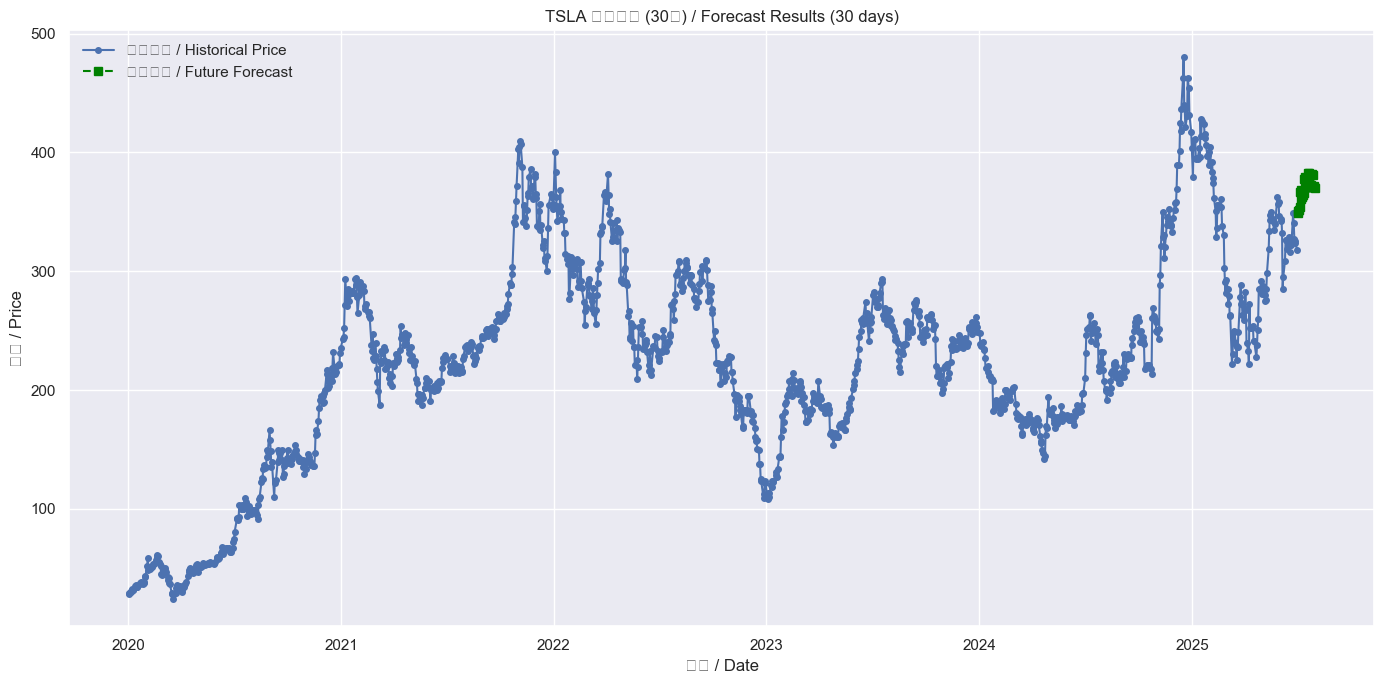

预测结果 (未来30天):


,Forecast
ds,
2025-07-01,348.936063
2025-07-02,350.518840
2025-07-03,351.612352
2025-07-04,354.000954
2025-07-05,366.590639
2025-07-06,368.463516
2025-07-07,361.003141
2025-07-08,362.059164
2025-07-09,363.365259


In [12]:
# 步骤11：Prophet模型预测 (终极健壮版本)
# Step 11: Prophet Model Forecasting (Ultimate Robust Version)
# ===========================================================
def robust_prophet_forecast(data, periods=30):
    """健壮的Prophet预测 / Robust Prophet Forecasting"""
    print("使用Prophet模型进行预测...")
    
    # 准备数据副本以避免修改原始数据
    data_copy = data.copy()
    
    try:
        # 准备Prophet所需格式
        df = data_copy.reset_index()[['Date', 'Close']].copy()
        df.columns = ['ds', 'y']  # 直接重命名列
        
        # 确保日期格式正确
        df['ds'] = pd.to_datetime(df['ds'])
        
        # 检查缺失值 - 使用更安全的方法
        missing_values = df['y'].isnull().sum()
        if missing_values > 0:
            print(f"警告: 数据中存在 {missing_values} 个缺失值，将使用前向填充")
            df['y'] = df['y'].fillna(method='ffill')
        
        # 创建Prophet模型 - 使用最简参数
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        
        # 尝试拟合模型
        model.fit(df)
        
        # 创建未来日期
        future = model.make_future_dataframe(periods=periods)
        
        # 预测
        forecast = model.predict(future)
        
        # 提取预测结果
        prophet_pred = forecast[['ds', 'yhat']].set_index('ds')['yhat']
        prophet_history = prophet_pred[:-periods]
        prophet_future = prophet_pred[-periods:]
        
        print("Prophet预测成功")
        return prophet_history, prophet_future
        
    except Exception as e:
        print(f"Prophet预测失败: {e}")
        print("使用改进的备选预测方法")
        
        # 改进的备选预测方法：加权移动平均 + 趋势外推
        last_date = data_copy.index[-1]
        
        # 计算可用数据点数量
        n_available = min(30, len(data_copy))
        
        # 计算加权平均值
        if n_available > 0:
            # 获取最近的数据点
            recent_data = data_copy['Close'].iloc[-n_available:].values
            
            # 创建权重数组 - 长度与可用数据点匹配
            weights = np.linspace(0.1, 1.0, n_available)
            
            # 手动计算加权平均值
            total_weight = np.sum(weights)
            weighted_sum = np.sum(recent_data * weights)
            weighted_avg = weighted_sum / total_weight
        else:
            # 如果没有数据，使用默认值
            weighted_avg = data_copy['Close'].mean() if len(data_copy) > 0 else 100.0
            print(f"警告: 没有足够数据计算加权平均，使用 {weighted_avg} 作为基准值")
        
        # 计算近期趋势
        trend_window = min(10, len(data_copy))
        if trend_window > 1:
            # 手动计算百分比变化
            price_values = data_copy['Close'].iloc[-trend_window:].values
            changes = []
            for i in range(1, len(price_values)):
                if price_values[i-1] != 0:  # 避免除以零
                    change = (price_values[i] - price_values[i-1]) / price_values[i-1]
                    changes.append(change)
            
            if changes:
                avg_change = np.mean(changes)
                trend_factor = 1 + avg_change
            else:
                trend_factor = 1.0  # 没有变化数据，使用中性趋势
                print("警告: 无法计算变化率，使用中性趋势")
        else:
            trend_factor = 1.0  # 数据不足，使用中性趋势
            print("警告: 数据不足，无法计算趋势")
        
        # 创建未来预测
        forecast_values = [weighted_avg * (trend_factor ** i) for i in range(1, periods + 1)]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)
        
        # 创建结果
        prophet_history = data_copy['Close']
        prophet_future = pd.Series(forecast_values, index=future_dates, name='yhat')
        
        return prophet_history, prophet_future

# 使用健壮的Prophet预测
prophet_history, prophet_future = robust_prophet_forecast(stock_data, FORECAST_DAYS)

# 绘制预测结果
plt.figure(figsize=(14, 7))

# 绘制历史数据
plt.plot(stock_data.index, stock_data['Close'], 'o-', label='历史价格 / Historical Price', markersize=4)

# 绘制未来预测
plt.plot(prophet_future.index, prophet_future.values, 's--', label='未来预测 / Future Forecast', color='green')

plt.title(f'{TICKER} 预测结果 ({FORECAST_DAYS}天) / Forecast Results ({FORECAST_DAYS} days)')
plt.xlabel('日期 / Date')
plt.ylabel('价格 / Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{TICKER}_forecast_results.png')  # 保存图表
plt.show()

# 创建预测结果表
prophet_df = prophet_future.to_frame('Forecast')

print(f"预测结果 (未来{FORECAST_DAYS}天):")
display(prophet_df.head(10))

图表时间范围: 2025-06-23 至 2025-09-28
包含: 最近7天实际数据 + 未来90天预测

重新运行ARIMA预测90天...
使用ARIMA模型进行预测...
重新运行Prophet预测90天...


c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\AA Py playground\Tesla-Stock-Prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

图表已保存为: TSLA_3month_forecast_20250630.png


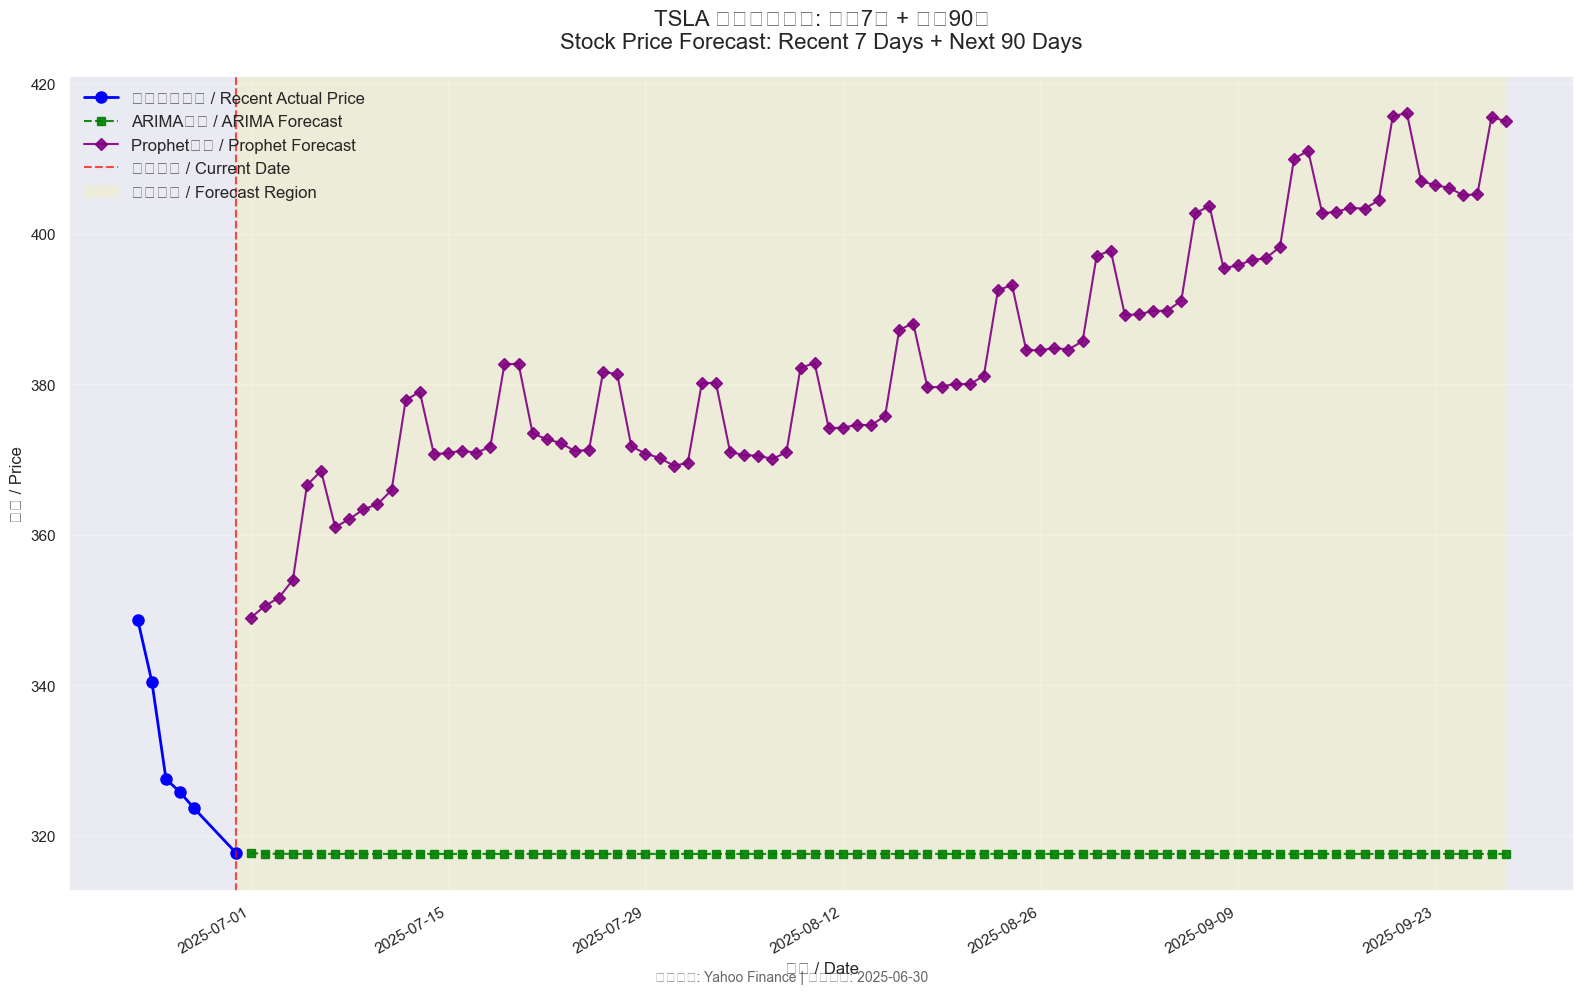


关键时间点预测:
30天后 (2025-07-30):
  ARIMA预测: 317.59
  Prophet预测: 370.20
  平均预测: 343.90
--------------------------------------------------
60天后 (2025-08-29):
  ARIMA预测: 317.59
  Prophet预测: 385.71
  平均预测: 351.65
--------------------------------------------------
90天后 (2025-09-28):
  ARIMA预测: 317.59
  Prophet预测: 414.94
  平均预测: 366.26
--------------------------------------------------
预测结果已保存为: TSLA_3month_forecast_20250630.csv


In [13]:
# 步骤12：未来预测图表（最终修复版）
# Step 12: Future Forecast Chart (Final Fixed Version)
# ===================================================

# 导入必要的模块
import matplotlib.dates as mdates

# 设置预测时间范围
FORECAST_DAYS = 90  # 3个月预测
recent_days = 7     # 显示最近7天实际数据

# 使用数据集的最后日期作为当前日期
current_date = stock_data.index[-1]
start_date = current_date - pd.Timedelta(days=recent_days)
end_date = current_date + pd.Timedelta(days=FORECAST_DAYS)

print(f"图表时间范围: {start_date.strftime('%Y-%m-%d')} 至 {end_date.strftime('%Y-%m-%d')}")
print(f"包含: 最近{recent_days}天实际数据 + 未来{FORECAST_DAYS}天预测")

# 修复ARIMA预测函数
def robust_arima_forecast(data, order=(5,1,0), forecast_days=30):
    """健壮的ARIMA预测 / Robust ARIMA Forecasting"""
    try:
        print("使用ARIMA模型进行预测...")
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=forecast_days)
        return forecast.values
    except Exception as e:
        print(f"ARIMA预测失败: {e}")
        print("使用简单移动平均作为备选预测")
        
        # 简单移动平均备选方案
        last_30_days = data[-30:].mean()
        return np.array([last_30_days] * forecast_days)

# 修复Prophet预测函数
def robust_prophet_forecast(data, periods=30):
    """健壮的Prophet预测 / Robust Prophet Forecasting"""
    try:
        # 准备Prophet所需格式
        df = data.reset_index()[['Date', 'Close']].copy()
        df.columns = ['ds', 'y']
        df['ds'] = pd.to_datetime(df['ds'])
        
        # 处理缺失值
        df['y'] = df['y'].fillna(method='ffill')
        
        # 创建Prophet模型
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        model.fit(df)
        
        # 创建未来日期
        future = model.make_future_dataframe(periods=periods)
        forecast = model.predict(future)
        
        # 提取预测结果
        return forecast[['ds', 'yhat']].set_index('ds')['yhat'].iloc[-periods:].values
        
    except Exception as e:
        print(f"Prophet预测失败: {e}")
        print("使用简单趋势外推作为备选预测")
        
        # 简单趋势外推备选方案
        last_price = data['Close'].iloc[-1]
        last_10_days = data['Close'][-10:].pct_change().dropna().mean()
        trend_factor = 1 + (last_10_days if not pd.isna(last_10_days) else 0.0)
        return np.array([last_price * (trend_factor ** i) for i in range(1, periods + 1)])

# 重新运行ARIMA预测90天
print("\n重新运行ARIMA预测90天...")
arima_pred_90d = robust_arima_forecast(stock_data['Close'], ARIMA_ORDER, FORECAST_DAYS)
arima_dates_90d = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=FORECAST_DAYS)

# 重新运行Prophet预测90天
print("重新运行Prophet预测90天...")
prophet_pred_90d = robust_prophet_forecast(stock_data, FORECAST_DAYS)
prophet_dates_90d = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=FORECAST_DAYS)

# 准备实际数据（最近7天）
recent_data = stock_data[stock_data.index >= (current_date - pd.Timedelta(days=recent_days))]['Close']

# 创建综合图表
plt.figure(figsize=(16, 10))

# 1. 绘制最近7天实际数据
plt.plot(recent_data.index, recent_data, 'o-', linewidth=2, 
         label='近期实际价格 / Recent Actual Price', color='blue', markersize=8)

# 2. 绘制ARIMA预测
plt.plot(arima_dates_90d, arima_pred_90d, 's--', linewidth=1.5, 
         label='ARIMA预测 / ARIMA Forecast', color='green', markersize=6, alpha=0.9)

# 3. 绘制Prophet预测
plt.plot(prophet_dates_90d, prophet_pred_90d, 'D-', linewidth=1.5, 
         label='Prophet预测 / Prophet Forecast', color='purple', markersize=6, alpha=0.9)

# 添加当前日期垂直线
plt.axvline(x=current_date, color='red', linestyle='--', alpha=0.7, label='当前日期 / Current Date')

# 添加预测区域
plt.axvspan(current_date, end_date, facecolor='yellow', alpha=0.1, label='预测区域 / Forecast Region')

# 设置标题和标签
plt.title(f'{TICKER} 股票价格预测: 最近{recent_days}天 + 未来{FORECAST_DAYS}天\nStock Price Forecast: Recent {recent_days} Days + Next {FORECAST_DAYS} Days', 
          fontsize=16, pad=20)
plt.xlabel('日期 / Date', fontsize=12)
plt.ylabel('价格 / Price', fontsize=12)

# 格式化日期轴
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# 添加网格和图例
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper left')

# 添加数据来源和预测日期标注
plt.figtext(0.5, 0.01, f"数据来源: Yahoo Finance | 预测日期: {current_date.strftime('%Y-%m-%d')}", 
            ha='center', fontsize=10, alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # 为底部文本留出空间

# 保存图表
chart_filename = f'{TICKER}_3month_forecast_{current_date.strftime("%Y%m%d")}.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
print(f"图表已保存为: {chart_filename}")

# 显示图表
plt.show()

# 创建预测结果表
forecast_comparison = pd.DataFrame({
    'Date': arima_dates_90d,
    'ARIMA_Forecast': arima_pred_90d,
    'Prophet_Forecast': prophet_pred_90d
}).set_index('Date')

# 添加30天、60天、90天关键点
key_dates = {
    "30天后": 30,
    "60天后": 60,
    "90天后": 90
}

print("\n关键时间点预测:")
for label, days in key_dates.items():
    # 计算目标日期
    target_date = current_date + pd.Timedelta(days=days)
    
    # 找到最接近的日期（使用索引位置）
    closest_date = forecast_comparison.index[0] + pd.Timedelta(days=days-1)
    
    # 确保日期在预测范围内
    if closest_date > forecast_comparison.index[-1]:
        closest_date = forecast_comparison.index[-1]
    
    arima_val = forecast_comparison.loc[closest_date, 'ARIMA_Forecast']
    prophet_val = forecast_comparison.loc[closest_date, 'Prophet_Forecast']
    
    print(f"{label} ({closest_date.strftime('%Y-%m-%d')}):")
    print(f"  ARIMA预测: {arima_val:.2f}")
    print(f"  Prophet预测: {prophet_val:.2f}")
    print(f"  平均预测: {(arima_val + prophet_val)/2:.2f}")
    print("-" * 50)

# 保存预测结果
forecast_filename = f'{TICKER}_3month_forecast_{current_date.strftime("%Y%m%d")}.csv'
forecast_comparison.to_csv(forecast_filename)
print(f"预测结果已保存为: {forecast_filename}")